In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

# Making results folder -- change to what this should actually be 
path = '/Volumes/Seagate Desktop Drive/kdata/'
os.chdir(path)
output_dir = Path.cwd() / "results" / "surface" / "first_level_results"
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Output will be saved to: {output_dir}")

#isolating directory called layout_raw (for events.tsv files) -- will change depending on where data is stored / what computer we're running on
layout_raw = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/kdata/', validate=True)

#isolating directory called layout (for fMRIprep derivatives) -- will change depending on where data is stored / what computer we're running on 
layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/kdata/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)

Output will be saved to: /Volumes/Seagate Desktop Drive/kdata/results/surface/first_level_results
BIDS Layout: ...esktop Drive/kdata/derivatives | Subjects: 58 | Sessions: 110 | Runs: 174


In [4]:
# needed for making design matrix 
# note: keep MNI files for isolating tr / frames bc easier to load 
def load_bids_events(layout,layout_raw, subject, run, session):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = 2.5 #put in manually bc get_tr wouldn't work?? 
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task='selfother',session = session,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files[run])
    n_tr = func_file.shape[-1]

    onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events', session = session)[run].path)
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as "onsets_actua
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

In [5]:
subjects = layout.get_subjects()
subjects

#sub119 sub225 still running on fmriprep -- kelly will update when done 
#sub132, sub136, sub150, sub229, sub239 ses02 was not added to kdata on sandisk -- also have to run via fmriprep 

['102',
 '103',
 '107',
 '109',
 '110',
 '111',
 '113',
 '114',
 '115',
 '117',
 '118',
 '119',
 '120',
 '122',
 '123',
 '125',
 '126',
 '127',
 '128',
 '129',
 '132',
 '136',
 '138',
 '139',
 '140',
 '143',
 '144',
 '145',
 '147',
 '150',
 '202',
 '204',
 '205',
 '206',
 '208',
 '209',
 '211',
 '212',
 '213',
 '214',
 '215',
 '216',
 '217',
 '218',
 '221',
 '223',
 '225',
 '226',
 '227',
 '229',
 '232',
 '233',
 '234',
 '235',
 '236',
 '237',
 '238',
 '239']

In [6]:
# subjects missing ses02:
# 102, 138, 145, 209, 221, 237 
subjects2 = []
subjects2 = subjects
#subjects2 = subjects
#testing second level (removing all subs with errors) 
del(subjects2[0]) #- 102 
del(subjects2[21]) #- 138 +1
del(subjects2[25]) #- 145 +1 
del(subjects2[32]) #- 209 +1 
del(subjects2[40]) #- 221 +1 
del(subjects2[50]) #- 237 +2 

subjects2

['103',
 '107',
 '109',
 '110',
 '111',
 '113',
 '114',
 '115',
 '117',
 '118',
 '119',
 '120',
 '122',
 '123',
 '125',
 '126',
 '127',
 '128',
 '129',
 '132',
 '136',
 '139',
 '140',
 '143',
 '144',
 '147',
 '150',
 '202',
 '204',
 '205',
 '206',
 '208',
 '211',
 '212',
 '213',
 '214',
 '215',
 '216',
 '217',
 '218',
 '223',
 '225',
 '226',
 '227',
 '229',
 '232',
 '233',
 '234',
 '235',
 '236',
 '238',
 '239']

In [7]:
subjects = layout.get_subjects()
subjects

['102',
 '103',
 '107',
 '109',
 '110',
 '111',
 '113',
 '114',
 '115',
 '117',
 '118',
 '119',
 '120',
 '122',
 '123',
 '125',
 '126',
 '127',
 '128',
 '129',
 '132',
 '136',
 '138',
 '139',
 '140',
 '143',
 '144',
 '145',
 '147',
 '150',
 '202',
 '204',
 '205',
 '206',
 '208',
 '209',
 '211',
 '212',
 '213',
 '214',
 '215',
 '216',
 '217',
 '218',
 '221',
 '223',
 '225',
 '226',
 '227',
 '229',
 '232',
 '233',
 '234',
 '235',
 '236',
 '237',
 '238',
 '239']

In [8]:
# to iterate through subjects ... 
#for sub in subjects 
from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists_lh = {"self-other": list(),
    "other-fix": list(),
     "self-fix": list(),
     "case-fix": list()
    }

sub_order_lh = {"self-other": list(),
    "other-fix": list(),
     "self-fix": list(),
     "case-fix": list()
    }

file_lists_rh = {"self-other": list(),
    "other-fix": list(),
     "self-fix": list(),
     "case-fix": list()
    }

sub_order_rh = {"self-other": list(),
    "other-fix": list(),
     "self-fix": list(),
     "case-fix": list()
    }

nosessions = ['01','02']
hemispheres = ['L','R']


for sess in nosessions: 

    if sess == '01':
        subject_list = subjects
    elif sess == '02':
        subject_list = subjects2
    
    for sub in subject_list: 
        
        for hemi in hemispheres:

# change lines below -- can change to "mask", change task to "self-other" -- should match the same format as in the load_bids_events function
            fmri_path = layout.get(subject=sub,
                                datatype='func', task='selfother',session = sess,
                                hemi=hemi,
                                space='fsaverage',
                                extension='func.gii',
                               return_type='file')
            
            data = []
            for con_img in fmri_path:
                data.append(np.array(load(con_img).agg_data('time series')))
            data = np.concatenate(data,axis=1)
            hrf_model = "spm" #canonical hrf 
            high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.
    
            confound_files = layout.get(subject=sub,
                            datatype='func', task='selfother',session = sess,
                            desc='confounds',
                           extension="tsv",
                           return_type='file')
    
    # Select confounds 
            #24 confound vars: 
          #  confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
          #                   'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
          #                   'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
          #                   'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
          #                   'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
          #                  'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2']
            #36 confound vars:
            confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                             'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'global_signal','global_signal_derivative1','global_signal_derivative1_power2','global_signal_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                            ]
            final_confounds = confound_vars
    
            design_matrices = []
    
            print("Creating First Level Design matrix ... ")
    
            for idx, img in enumerate(fmri_path):
    # Build experimental paradigm
                run = idx
                events,tr,n_scans = load_bids_events(layout,layout_raw, sub, run, sess)
        # Define the sampling times for the design matrix
                frame_times = np.arange(n_scans) * tr
                confound_file = confound_files[run]
                confound_df = pd.read_csv(confound_file, delimiter='\t')
                confound_df = confound_df[final_confounds]
                confound_df.fillna(0, inplace=True)
        # Build design matrix with the previously defined parameters
                design_matrix = make_first_level_design_matrix(
                    frame_times,
                    events,
                    hrf_model=hrf_model,
                    drift_model="polynomial",
                    drift_order=3,
                    add_regs=confound_df,
                    add_reg_names=confound_vars,
                    high_pass=high_pass,
                )
                design_matrix = design_matrix.iloc[:,0:11] # taking out constant intercept and adding in an intercept for each individual run
    # this allows average voxel to vary across runs instead of assuming its constant 
                if idx == 0:
                    design_matrix['intercept1'] = 1 
                    design_matrix['intercept2'] = 0
                    design_matrix['intercept3'] = 0
                elif idx == 1:
                    design_matrix['intercept1'] = 0
                    design_matrix['intercept2'] = 1 
                    design_matrix['intercept3'] = 0
                else: 
                    design_matrix['intercept1'] = 0
                    design_matrix['intercept2'] = 0 
                    design_matrix['intercept3'] = 1
        # put the design matrices in a list / concatenate 
                design_matrices.append(design_matrix)
            design_matrix_allruns = []    
            design_matrix_allruns = np.concatenate(design_matrices, axis = 0)
    
            print("First Level Design Matrix completed")
    
            contrast_matrix = np.eye(design_matrix.shape[1])
            basic_contrasts = {
                column: contrast_matrix[i]
                for i, column in enumerate(design_matrix.columns)
            }
    
            contrasts = {
                "self-other": (basic_contrasts["self"] - basic_contrasts["other"]),
                "self-fix": (basic_contrasts["self"] - basic_contrasts["fix"]),
                "other-fix": (basic_contrasts["other"] - basic_contrasts["fix"]),
                "case-fix": (basic_contrasts["case"] - basic_contrasts["fix"]),
    
            }
    
            print("Fitting first-level GLM ...")
            labels, estimates = run_glm(data.T, design_matrix_allruns)
    
            print("First-level completed!")
    
            print("Computing contrasts")
    
        # Iterate on contrasts
            for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):

    # compute contrast-related statistics
                contrast = compute_contrast(labels, estimates, contrast_val)
    # we present the Z-transform of the t map
                z_score = contrast.z_score()
    # we plot it on the surface, on the inflated fsaverage mesh,
    # together with a suitable background to give an impression
    # of the cortex folding.
                
# commented out plotting sections bc of how much memory it takes -- uncomment if you want to see every subjects 1st level output for each contrast 
               # plotting.plot_surf_stat_map(
               #     fsaverage.infl_left, z_score, hemi='left', view='lateral',
               #     title=contrast_id, colorbar=True,
                #     threshold=3., bg_map=fsaverage.sulc_left)
               # plotting.show()
               # plotting.plot_surf_stat_map(
                #    fsaverage.infl_left, z_score, hemi='left', view='medial',
                 #   title=contrast_id, colorbar=True,
                  #  threshold=3., bg_map=fsaverage.sulc_left)
                #plotting.show()
                if hemi == 'R': 
                    file_lists_rh[contrast_id].append(contrast)
                    sub_order_rh[contrast_id].append('sub'+ sub + '-ses' + sess)
                else: 
                    file_lists_lh[contrast_id].append(contrast)
                    sub_order_lh[contrast_id].append('sub'+ sub + '-ses' + sess)
    
        print("Subject = " + sub + " Completed!")
            

Creating First Level Design matrix ... 
First Level Design Matrix completed
Fitting first-level GLM ...
First-level completed!
Computing contrasts
Creating First Level Design matrix ... 
First Level Design Matrix completed
Fitting first-level GLM ...
First-level completed!
Computing contrasts
Subject = 102 Completed!
Creating First Level Design matrix ... 
First Level Design Matrix completed
Fitting first-level GLM ...
First-level completed!
Computing contrasts
Creating First Level Design matrix ... 
First Level Design Matrix completed
Fitting first-level GLM ...
First-level completed!
Computing contrasts
Subject = 103 Completed!
Creating First Level Design matrix ... 
First Level Design Matrix completed
Fitting first-level GLM ...
First-level completed!
Computing contrasts
Creating First Level Design matrix ... 
First Level Design Matrix completed
Fitting first-level GLM ...
First-level completed!
Computing contrasts
Subject = 107 Completed!
Creating First Level Design matrix ... 
Fir

In [9]:
# making second-level design matrix 

#QUESTION FOR KELLY -- SHOULD I BE USING 0'S OR -1? 

# patient group variable 
group1 = []
group2 = []
patients = []
for sub in subjects: 
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = 0
    group1.append(group_as)
for sub in subjects2: 
    if int(sub) < 200:
        group_as = 1
    else:
        group_as = 0
    group2.append(group_as)
patients = np.concatenate((np.array(group1),np.array(group2)))
patients = np.expand_dims(patients, axis = -1)

group1 = []
group2 = []
controls = []
for sub in subjects: 
    if int(sub) < 200:
        group_as = 0
    else:
        group_as = 1
    group1.append(group_as)
for sub in subjects2: 
    if int(sub) < 200:
        group_as = 0
    else:
        group_as = 1
    group2.append(group_as)
controls = np.concatenate((np.array(group1),np.array(group2)))
controls = np.expand_dims(controls, axis = -1)

# session variable
post = []
session1 = np.zeros(len(subjects))
session2 = np.ones(len(subjects2))
post = np.concatenate((session1,session2))
post = np.expand_dims(post, axis = -1)

# session variable
pre = []
session1 = np.ones(len(subjects))
session2 = np.zeros(len(subjects2))
pre = np.concatenate((session1,session2))
pre = np.expand_dims(pre, axis = -1)

#subject-wise intercept
sub_matrix = np.identity(len(subjects))
sub_matrix2 = np.delete(sub_matrix, 0, axis=0)  #- 102
sub_matrix2 = np.delete(sub_matrix2, 21, axis=0)  #- 138
sub_matrix2 = np.delete(sub_matrix2, 25, axis=0)  #- 145
sub_matrix2 = np.delete(sub_matrix2, 32, axis=0)  #- 209
sub_matrix2 = np.delete(sub_matrix2, 40, axis=0)  #- 221
sub_matrix2 = np.delete(sub_matrix2, 50, axis=0)  #- 237

sub_matrix = np.concatenate((sub_matrix,sub_matrix2))

# put all together 
second_level_design_matrix = np.hstack((patients,controls,pre,post,sub_matrix))

# delete out subs who didn't have second session ()

In [10]:
second_level_design_matrix.shape
#second_level_design_matrix

(110, 62)

In [11]:
#making second level input matrix -- 

#lh 
second_level_input_lh = []
for i in file_lists_lh['self-other']:
    second_level_input_lh.append(i.effect_size())
second_level_input_lh = np.concatenate(second_level_input_lh,axis=0)  

#rh 
second_level_input_rh = []
for i in file_lists_rh['self-other']:
    second_level_input_rh.append(i.effect_size())

second_level_input_rh = np.concatenate(second_level_input_rh,axis=0) 

In [14]:
# fitting second level glm! 
secondlevel_labels_lh, secondlevel_estimates_lh = run_glm(second_level_input_lh, second_level_design_matrix)
secondlevel_labels_rh, secondlevel_estimates_rh = run_glm(second_level_input_rh, second_level_design_matrix)

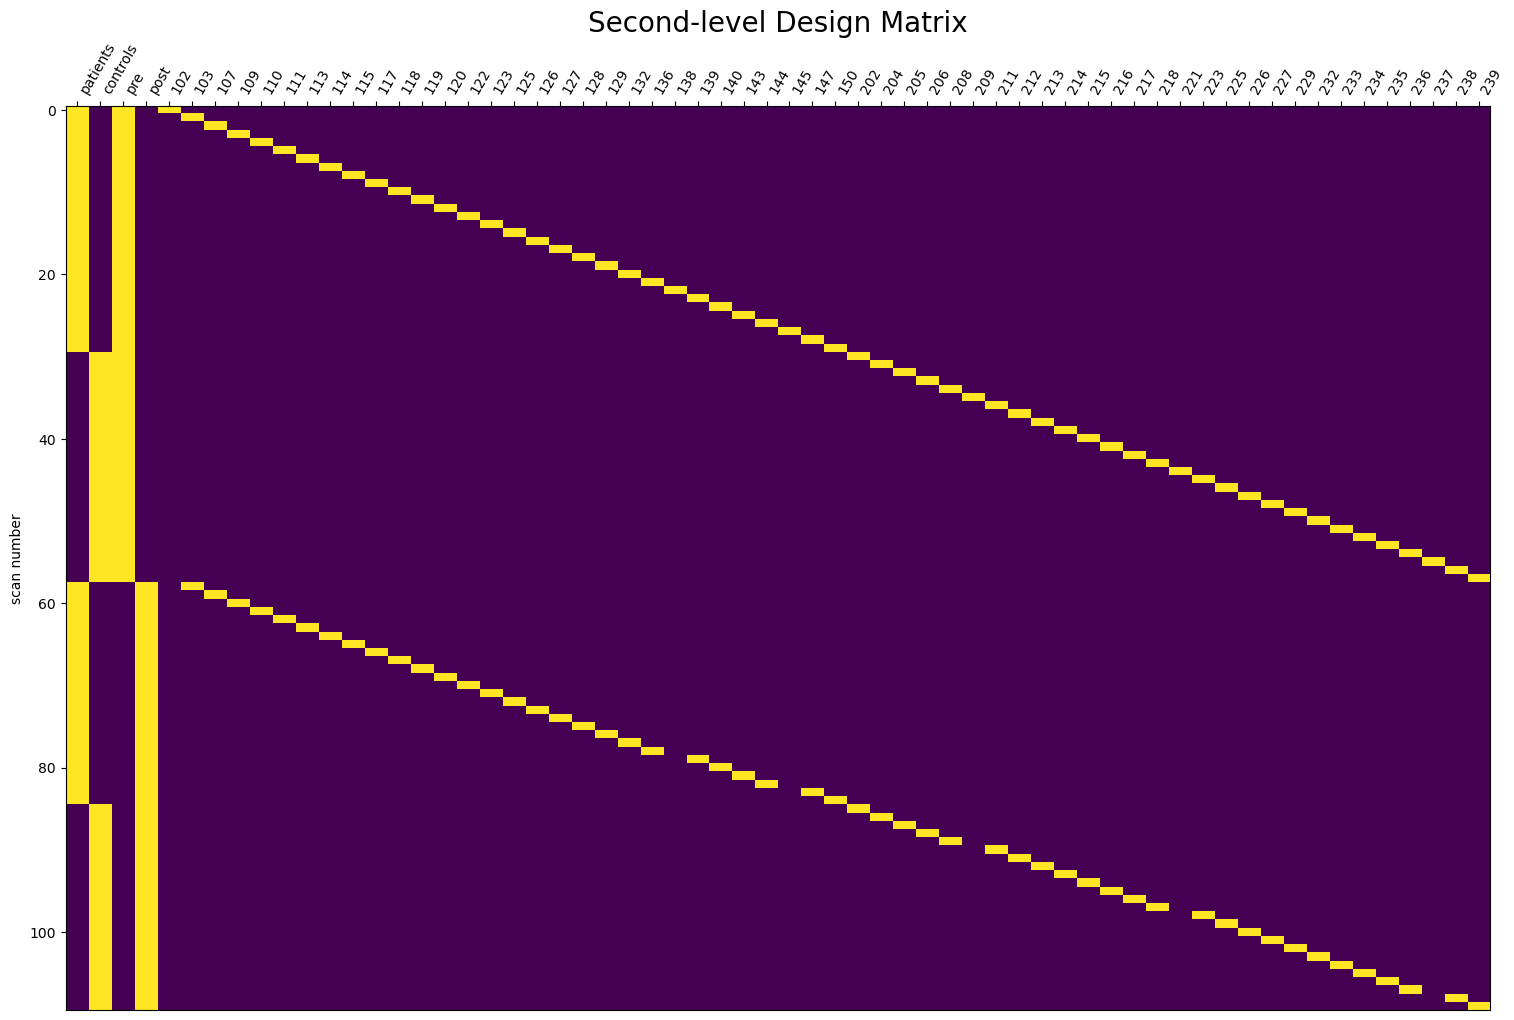

In [15]:
# plotting second level design matrix + adding column names for contrasts 
second_level_design_matrix = pd.DataFrame(second_level_design_matrix, columns=['patients'] + ['controls'] +['pre'] +['post'] + subjects)
second_level_design_matrix.to_excel("/Users/angelafang/Desktop/test.xlsx")

from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(second_level_design_matrix, rescale=False)
plt.title("Second-level Design Matrix", fontsize=20)
plotting.show()

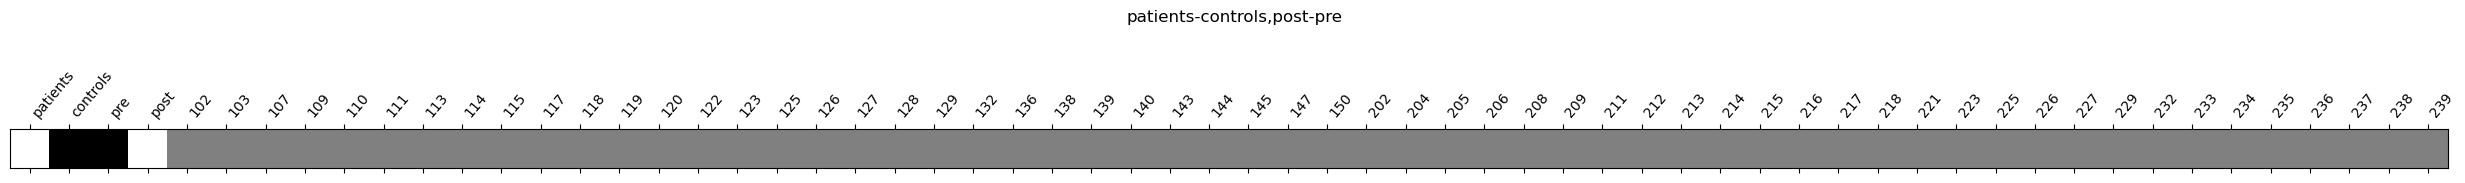

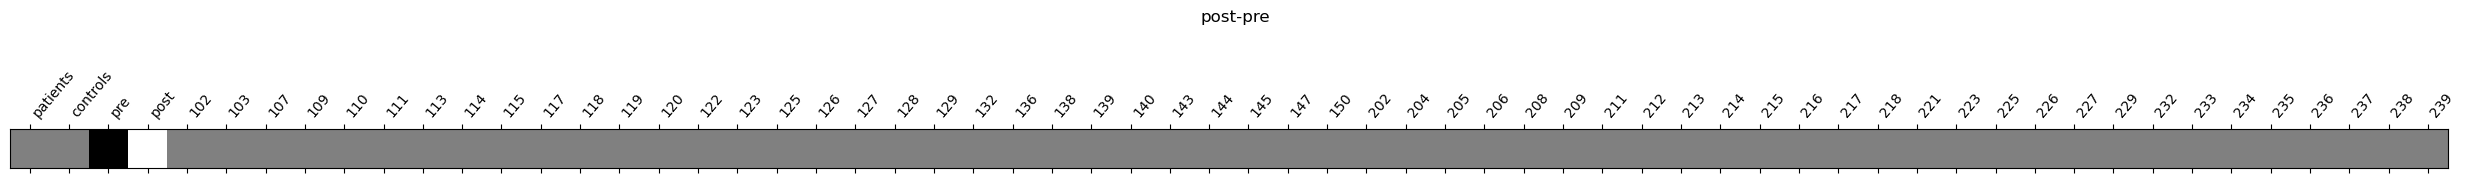

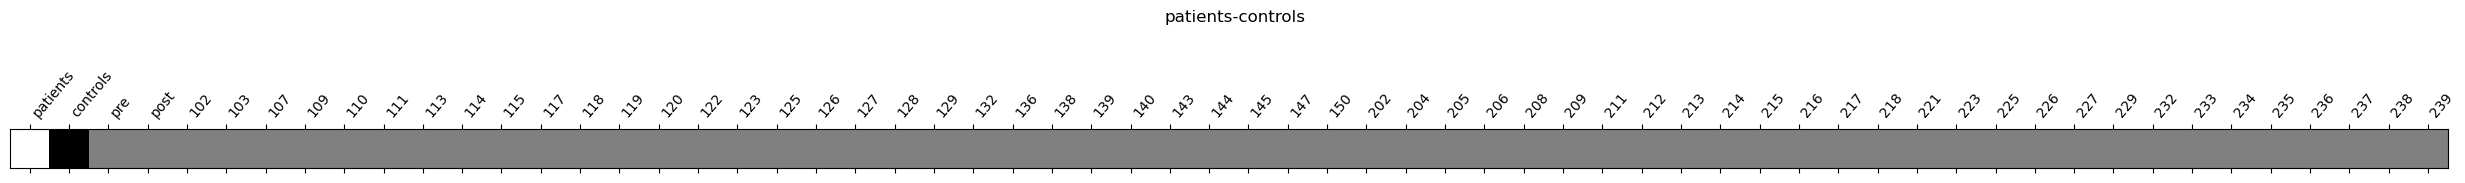

In [16]:
#Making contrasts! 
contrast_matrix = np.eye(second_level_design_matrix.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(second_level_design_matrix.columns)
    }

contrasts = {
    "patients-controls,post-pre": (basic_contrasts["patients"]-basic_contrasts["controls"]+basic_contrasts["post"]-basic_contrasts["pre"]),
    "post-pre": (basic_contrasts["post"]-basic_contrasts["pre"]),
    "patients-controls": (basic_contrasts["patients"]-basic_contrasts["controls"]),
    }      
contrasts

from nilearn.plotting import plot_contrast_matrix
for key, values in contrasts.items():
    plot_contrast_matrix(values, design_matrix=second_level_design_matrix)
    plt.suptitle(key)
plt.show()

In [17]:
second_level_design_matrix

,patients,controls,pre,post,102,103,107,109,110,111,...,227,229,232,233,234,235,236,237,238,239
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
106,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
107,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
108,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Patients-Controls Post-Pre p<0.001 uncorrected


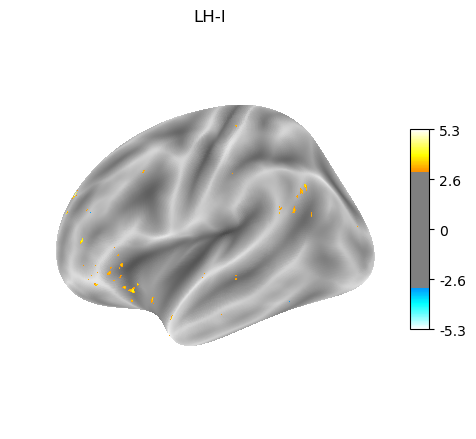

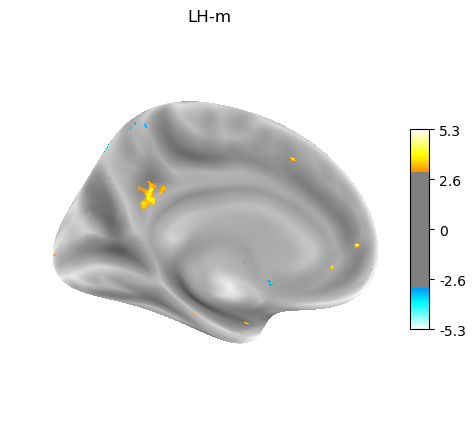

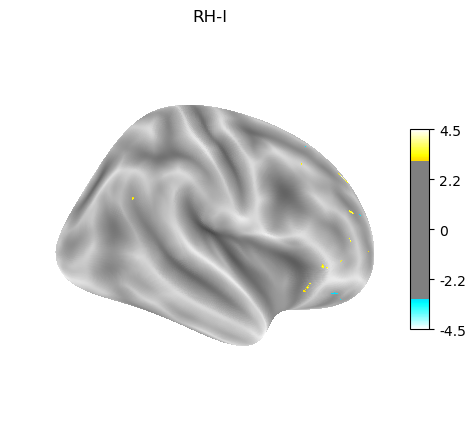

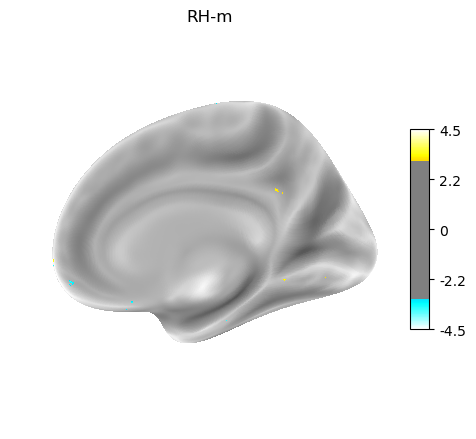

In [18]:
#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Patients-Controls Post-Pre p<0.001 uncorrected')

contrast_val = contrasts['patients-controls,post-pre'] 
contrast_id = 'Patients-Controls, Post-Pre'    

# LEFT HEMISPHERE: 
contrast = compute_contrast(secondlevel_labels_lh, secondlevel_estimates_lh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(fsaverage.infl_left, z_score, hemi='left', view='lateral',
    title="LH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score, hemi='left', view='medial',
    title="LH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

# RIGHT HEMISPHERE: 
contrast = compute_contrast(secondlevel_labels_rh, secondlevel_estimates_rh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='lateral',
    title="RH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='medial',
    title="RH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()


In [45]:
# Saving self-other z_maps 

z_map_lh = contrast.z_score()
z_scores_lh = z_map_lh.astype(np.float32)
z_scores_lh = z_scores_lh.reshape(163842, 1, 1)
# # Create an MGHImage
mgh_image_lh = nib.MGHImage(z_scores_lh, affine=np.eye(4))
# # Save the image to an .mgh file
nib.save(mgh_image_lh, '/Volumes/Seagate Desktop Drive/kdata/results/surface/second_level_results/lh.z_map.mgh')

z_map_rh = contrast.z_score()
z_scores_rh = z_map_rh.astype(np.float32)
z_scores_rh = z_scores_rh.reshape(163842, 1, 1)
# # Create an MGHImage
mgh_image_rh = nib.MGHImage(z_scores_rh, affine=np.eye(4))
# # Save the image to an .mgh file
nib.save(mgh_image_rh, '/Volumes/Seagate Desktop Drive/kdata/results/surface/second_level_results/rh.z_map.mgh')


In [81]:
#finding fdr threshold
import numpy as np

def fdr_threshold(p_values, alpha=0.05):
    # Sort p-values in ascending order
    sorted_indices = np.argsort(p_values)
    sorted_p_values = p_values[sorted_indices]

    # Calculate the critical value k
    num_tests = len(p_values)
    k = np.argmax(sorted_p_values > np.arange(1, num_tests + 1) * alpha / num_tests)

    # FDR threshold
    if k > 0:
        fdr_thresh = sorted_p_values[k - 1]
    else:
        fdr_thresh = 0.0

    return fdr_thresh

#lh
contrast = compute_contrast(secondlevel_labels_lh, secondlevel_estimates_lh, contrast_val)
z_map = contrast.p_value()
fdr_thresh_lh = fdr_threshold(z_map)
print(f"LH FDR thresh: {fdr_thresh_lh}")
#rh
contrast = compute_contrast(secondlevel_labels_rh, secondlevel_estimates_rh, contrast_val)
z_map = contrast.p_value()
fdr_thresh_rh = fdr_threshold(z_map)
print(f"RH FDR thresh: {fdr_thresh_rh}")

#fdr-combined? 
contrast = compute_contrast(secondlevel_labels_lh, secondlevel_estimates_lh, contrast_val)
z_map_lh = contrast.p_value()
contrast = compute_contrast(secondlevel_labels_rh, secondlevel_estimates_rh, contrast_val)
z_map_rh = contrast.p_value()
z_map_combo = np.concatenate((z_map_lh,z_map_rh))
fdr_thresh_combo = fdr_threshold(z_map_combo)
print(f"Combo FDR thresh: {fdr_thresh_combo}")


LH FDR thresh: 1.8175826902889882e-06
RH FDR thresh: 0.0
Combo FDR thresh: 5.912423609260063e-07


In [82]:
print(f'fdr p: {fdr_thresh_combo}')
fdr_z_combo = norm.isf(fdr_thresh_combo)
print(f'fdr z threshold: {fdr_z_combo}')


fdr p: 5.912423609260063e-07
fdr z threshold: 4.858550128298695


<Figure size 640x480 with 0 Axes>

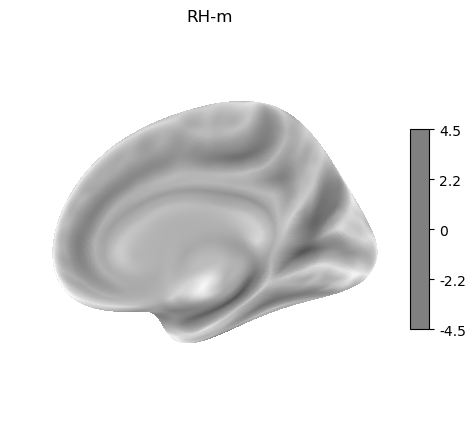

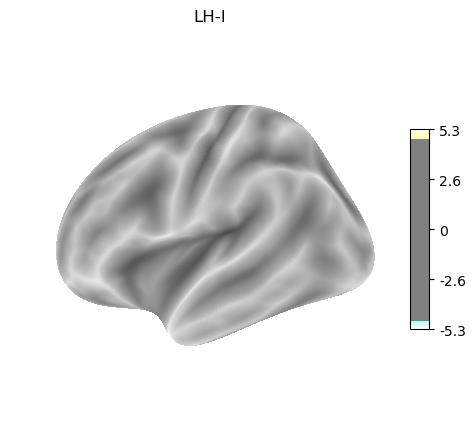

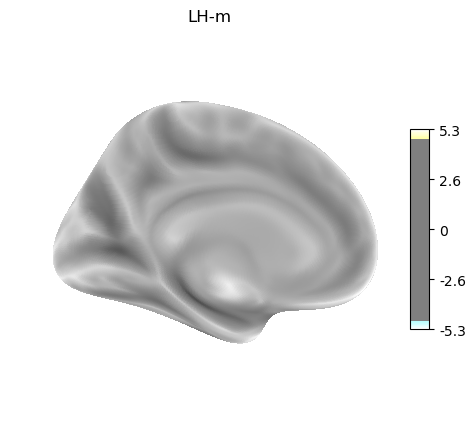

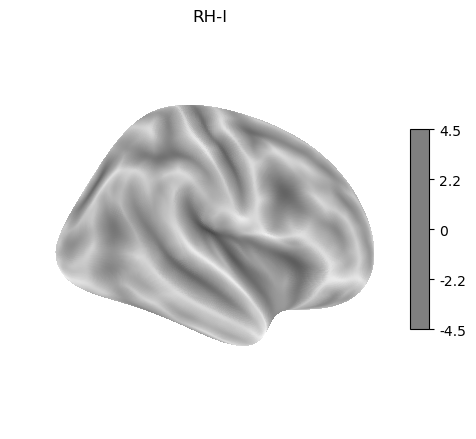

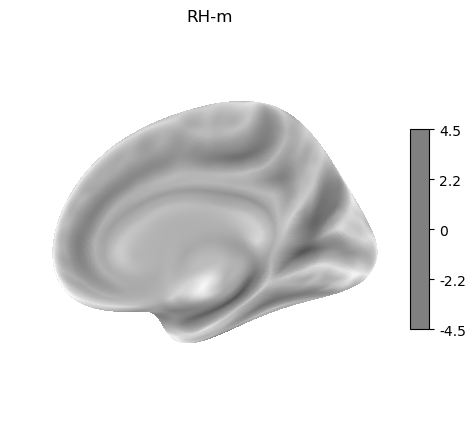

In [84]:
#Plotting! <0.05 fdr corrected  
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

fig = plt.figure()
# Add a bolded super title
fig.suptitle('Patients-Controls Post-Pre fdr p<0.05 ', fontsize=20, fontweight='bold')
# Show the figure
plt.show()

contrast_val = contrasts['patients-controls,post-pre'] 
contrast_id = 'Patients-Controls, Post-Pre'    

# LEFT HEMISPHERE: 
contrast = compute_contrast(secondlevel_labels_lh, secondlevel_estimates_lh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(fsaverage.infl_left, z_score, hemi='left', view='lateral',
    title="LH-l", colorbar=True,
    threshold=fdr_z_combo, bg_map=fsaverage.sulc_left)
plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score, hemi='left', view='medial',
    title="LH-m", colorbar=True,
    threshold=fdr_z_combo, bg_map=fsaverage.sulc_left)

# RIGHT HEMISPHERE: 
contrast = compute_contrast(secondlevel_labels_rh, secondlevel_estimates_rh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='lateral',
    title="RH-l", colorbar=True,
    threshold=fdr_z_combo, bg_map=fsaverage.sulc_right)
plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='medial',
    title="RH-m", colorbar=True,
    threshold=fdr_z_combo, bg_map=fsaverage.sulc_right)


In [85]:
count = np.sum(np.abs(z_map_combo) < fdr_thresh_combo)

print("Count:", count)

# Boolean mask for elements where abs(z_map) > fdr_z
mask = np.abs(z_map_combo) < fdr_thresh_combo

# Filter and print the elements of z_map where abs(z_map) > fdr_z
print("Elements of z_map greater than fdr_z:", z_map_combo[mask])

Count: 3
Elements of z_map greater than fdr_z: [6.89711397e-08 5.91412463e-08 6.77919429e-08]


Post-Pre p<0.001 uncorrected


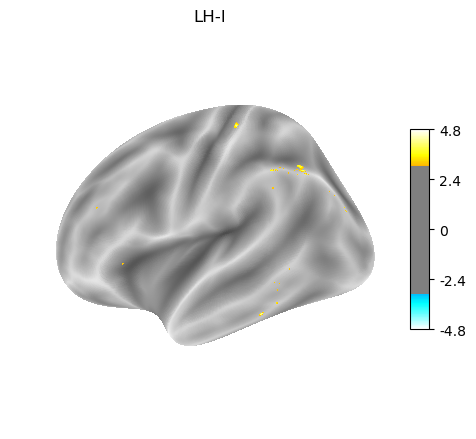

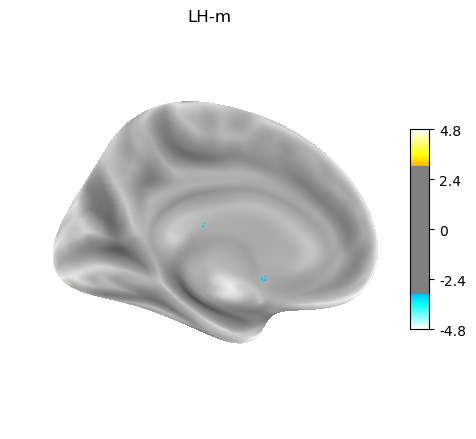

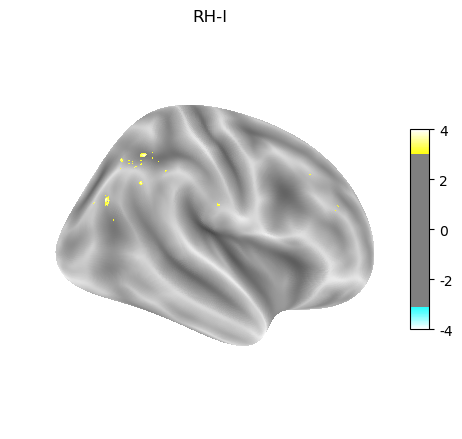

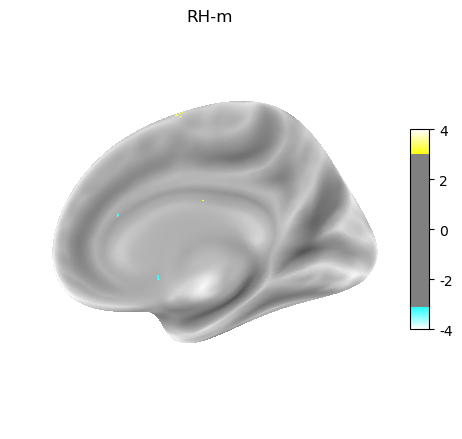

In [86]:
#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Post-Pre p<0.001 uncorrected')

contrast_val = contrasts['post-pre'] 
contrast_id = 'Post-Pre'    

# LEFT HEMISPHERE: 
contrast = compute_contrast(secondlevel_labels_lh, secondlevel_estimates_lh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(fsaverage.infl_left, z_score, hemi='left', view='lateral',
    title="LH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score, hemi='left', view='medial',
    title="LH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

# RIGHT HEMISPHERE: 
contrast = compute_contrast(secondlevel_labels_rh, secondlevel_estimates_rh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='lateral',
    title="RH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='medial',
    title="RH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()


Patients-Controls p<0.001 uncorrected


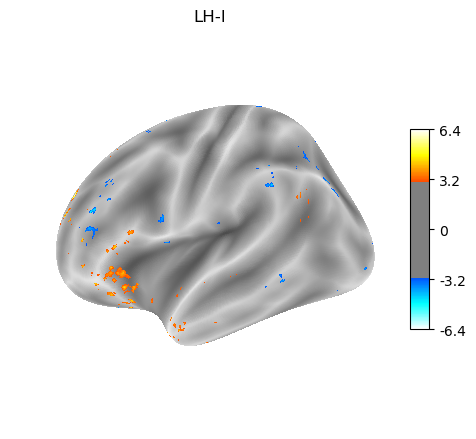

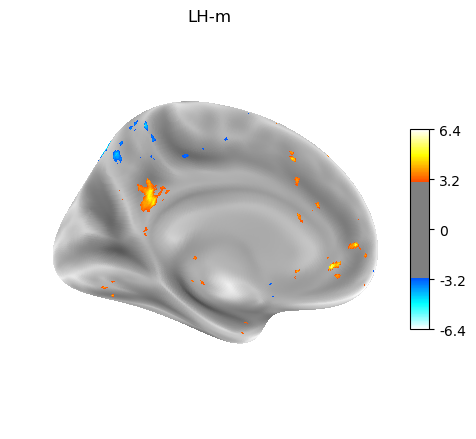

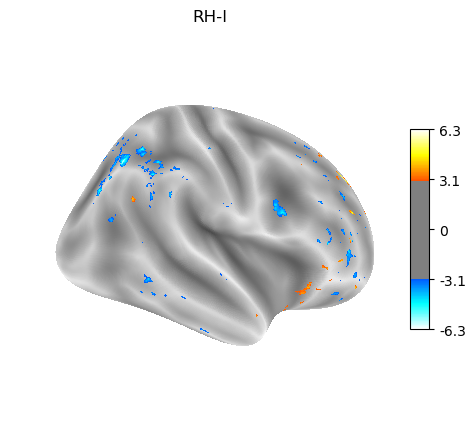

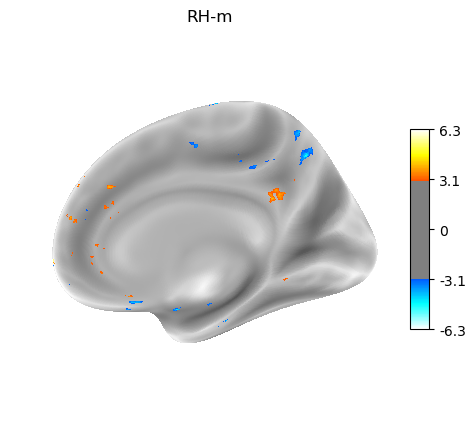

In [87]:
#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Patients-Controls p<0.001 uncorrected')

contrast_val = contrasts['patients-controls'] 
contrast_id = 'Patients-Controls'    

# LEFT HEMISPHERE: 
contrast = compute_contrast(secondlevel_labels_lh, secondlevel_estimates_lh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(fsaverage.infl_left, z_score, hemi='left', view='lateral',
    title="LH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score, hemi='left', view='medial',
    title="LH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

# RIGHT HEMISPHERE: 
contrast = compute_contrast(secondlevel_labels_rh, secondlevel_estimates_rh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='lateral',
    title="RH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='medial',
    title="RH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()


In [ ]:
#### POST-HOC TESTS WITHIN-GROUP POST-PRE ####

In [88]:
# separating input matrix for post-hoc tests 

#lh 
second_level_input_lh = []
for i in file_lists_lh['self-other']:
    second_level_input_lh.append(i.effect_size())

second_level_input_lh = np.concatenate(second_level_input_lh,axis=0)  

#rh 
second_level_input_rh = []
for i in file_lists_rh['self-other']:
    second_level_input_rh.append(i.effect_size())

second_level_input_rh = np.concatenate(second_level_input_rh,axis=0) 

# Separate sessions and create sets for quick lookup
ses01_patients = {entry for entry in sub_order_rh['self-other'] if entry.startswith('sub1') and entry.endswith('ses01')}
ses01_patient_indices = [i for i, entry in enumerate(sub_order_rh['self-other']) if entry.startswith('sub1') and entry.endswith('ses01')]
ses01_patient_data_rh = np.array([second_level_input_rh[i] for i in ses01_patient_indices])
ses01_patient_data_lh = np.array([second_level_input_lh[i] for i in ses01_patient_indices])

ses02_patients = {entry for entry in sub_order_rh['self-other'] if entry.startswith('sub1') and entry.endswith('ses02')}
ses02_patient_indices = [i for i, entry in enumerate(sub_order_rh['self-other']) if entry.startswith('sub1') and entry.endswith('ses02')]
ses02_patient_data_rh = np.array([second_level_input_rh[i] for i in ses02_patient_indices])
ses02_patient_data_lh = np.array([second_level_input_lh[i] for i in ses02_patient_indices])

ses01_controls = {entry for entry in sub_order_rh['self-other'] if entry.startswith('sub2') and entry.endswith('ses01')}
ses01_controls_indices = [i for i, entry in enumerate(sub_order_rh['self-other']) if entry.startswith('sub2') and entry.endswith('ses01')]
ses01_controls_data_rh = np.array([second_level_input_rh[i] for i in ses01_controls_indices])
ses01_controls_data_lh = np.array([second_level_input_lh[i] for i in ses01_controls_indices])

ses02_controls = {entry for entry in sub_order_rh['self-other'] if entry.startswith('sub2') and entry.endswith('ses02')}
ses02_controls_indices = [i for i, entry in enumerate(sub_order_rh['self-other']) if entry.startswith('sub2') and entry.endswith('ses02')]
ses02_controls_data_rh = np.array([second_level_input_rh[i] for i in ses02_controls_indices])
ses02_controls_data_lh = np.array([second_level_input_lh[i] for i in ses02_controls_indices])


In [89]:
#"PRE-POST" for controls / patients within-group differences   
#making second level input matrix -- 
controls_prevpost_lh = np.concatenate((ses01_controls_data_lh,ses02_controls_data_lh))
controls_prevpost_rh = np.concatenate((ses01_controls_data_rh,ses02_controls_data_rh))
patients_prevpost_lh = np.concatenate((ses01_patient_data_lh,ses02_patient_data_lh))
patients_prevpost_rh = np.concatenate((ses01_patient_data_rh,ses02_patient_data_rh))


In [90]:
patients_prevpost_lh.shape

(57, 163842)

In [91]:
#pre/post second level design matrices (patients / controls sep) 

#patients 
# session variable
pre = []
session1 = np.ones(len(ses01_patients))
session2 = np.zeros(len(ses02_patients))
pre = np.concatenate((session1,session2))
pre = np.expand_dims(pre, axis = -1)

post = []
session1 = np.zeros(len(ses01_patients))
session2 = np.ones(len(ses02_patients))
post = np.concatenate((session1,session2))
post = np.expand_dims(post, axis = -1)


#subject-wise intercept
sub_matrix = []
sub_matrix2 = []
sub_matrix = np.identity(len(ses01_patients))
sub_matrix2 = np.delete(sub_matrix, 0, axis=0)  #- 102
sub_matrix2 = np.delete(sub_matrix2, 21, axis=0)  #- 138
sub_matrix2 = np.delete(sub_matrix2, 25, axis=0)  #- 145

sub_matrix = np.concatenate((sub_matrix,sub_matrix2))

# put all together 
patients_prevpost_sldm = np.hstack((pre,post,sub_matrix))

#controls 
# session variable
pre = []
session1 = np.ones(len(ses01_controls))
session2 = np.zeros(len(ses02_controls))
pre = np.concatenate((session1,session2))
pre = np.expand_dims(pre, axis = -1)

post = []
session1 = np.zeros(len(ses01_controls))
session2 = np.ones(len(ses02_controls))
post = np.concatenate((session1,session2))
post = np.expand_dims(post, axis = -1)


#subject-wise intercept
sub_matrix = []
sub_matrix2 = []
sub_matrix = np.identity(len(ses01_controls))
sub_matrix2 = np.delete(sub_matrix, 5, axis=0)  #- 209
sub_matrix2 = np.delete(sub_matrix2, 13, axis=0)  #- 221
sub_matrix2 = np.delete(sub_matrix2, 23, axis=0)  #- 237

sub_matrix = np.concatenate((sub_matrix,sub_matrix2))

# put all together 
controls_prevpost_sldm = np.hstack((pre,post,sub_matrix))

In [92]:
patients = subjects[0:30]
controls = subjects[30:58]

In [93]:
# fitting second level glm! 
patients_labels_lh, patients_estimates_lh = run_glm(patients_prevpost_lh, patients_prevpost_sldm)
patients_labels_rh, patients_estimates_rh = run_glm(patients_prevpost_rh, patients_prevpost_sldm)

controls_labels_lh, controls_estimates_lh = run_glm(controls_prevpost_lh, controls_prevpost_sldm)
controls_labels_rh, controls_estimates_rh = run_glm(controls_prevpost_rh, controls_prevpost_sldm)

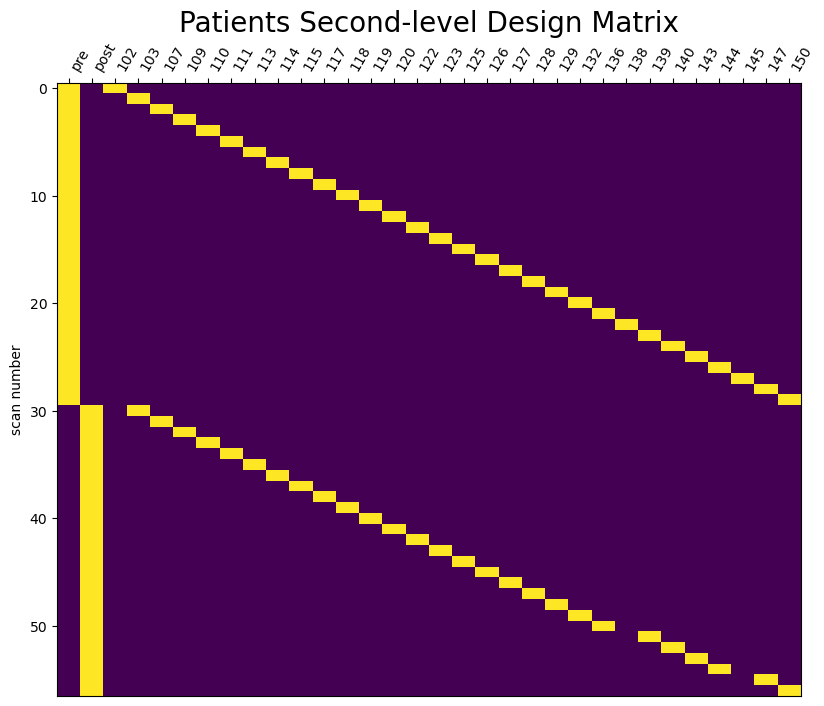

In [94]:
# plotting second level design matrix + adding column names for contrasts 
patients_prevpost_sldm = pd.DataFrame(patients_prevpost_sldm, columns=['pre'] +['post'] + patients)
patients_prevpost_sldm.to_excel("/Users/angelafang/Desktop/patients_prevpost_sldm.xlsx")

from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(patients_prevpost_sldm, rescale=False)
plt.title("Patients Second-level Design Matrix", fontsize=20)
plotting.show()

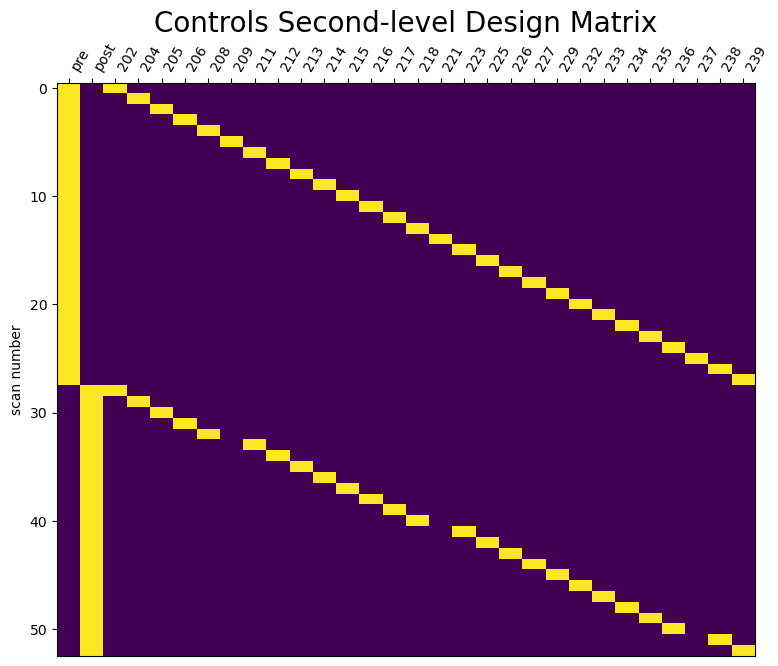

In [95]:
# plotting second level design matrix + adding column names for contrasts 
controls_prevpost_sldm = pd.DataFrame(controls_prevpost_sldm, columns=['pre'] +['post'] + controls)
controls_prevpost_sldm.to_excel("/Users/angelafang/Desktop/controls_prevpost_sldm.xlsx")

from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(controls_prevpost_sldm, rescale=False)
plt.title("Controls Second-level Design Matrix", fontsize=20)
plotting.show()

Patients Post-Pre p<0.001 uncorrected


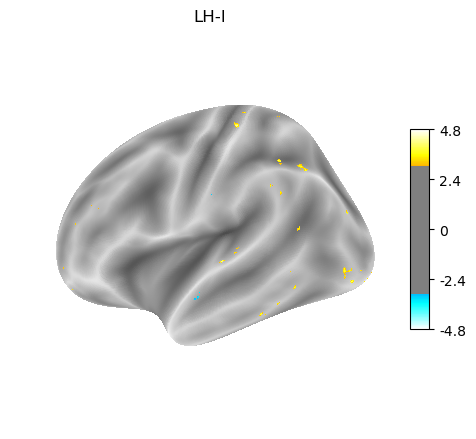

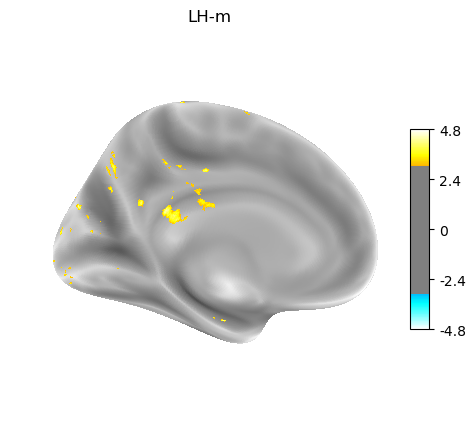

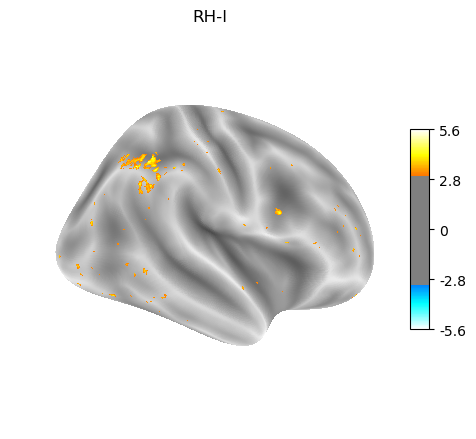

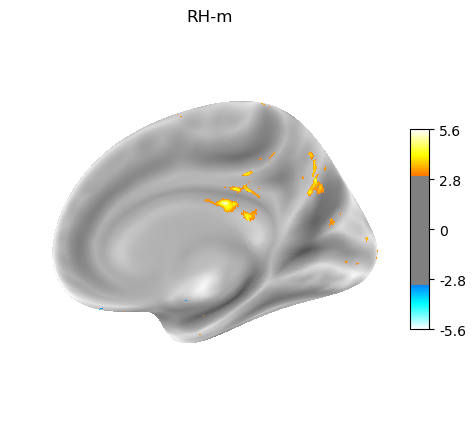

In [96]:
# PATIENTS POST-PRE (PLOTTING)
contrast_matrix = np.eye(patients_prevpost_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(patients_prevpost_sldm.columns)
    }

contrasts = {
    "post-pre": (basic_contrasts["post"]-basic_contrasts["pre"]),
    }      
contrasts

#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Patients Post-Pre p<0.001 uncorrected')

contrast_val = contrasts['post-pre'] 
contrast_id = 'Post-Pre'    

# LEFT HEMISPHERE: 
contrast = compute_contrast(patients_labels_lh, patients_estimates_lh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(fsaverage.infl_left, z_score, hemi='left', view='lateral',
    title="LH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score, hemi='left', view='medial',
    title="LH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

# RIGHT HEMISPHERE: 
contrast = compute_contrast(patients_labels_rh, patients_estimates_rh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='lateral',
    title="RH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='medial',
    title="RH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

Controls Post-Pre p<0.001 uncorrected


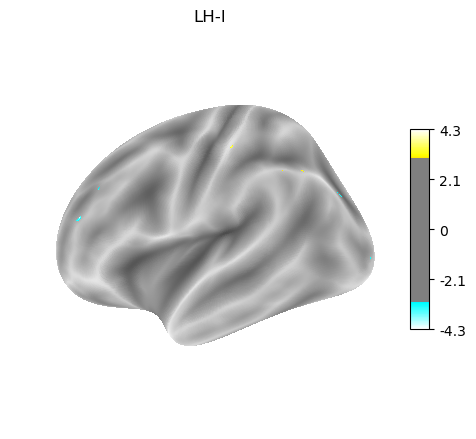

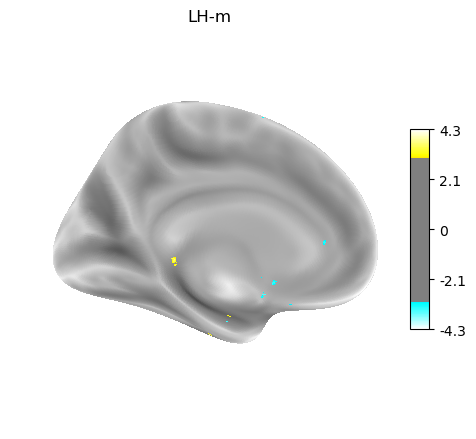

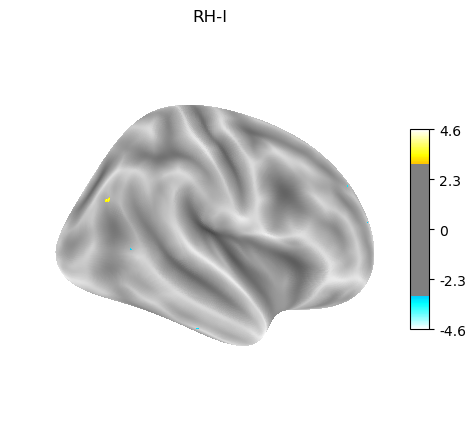

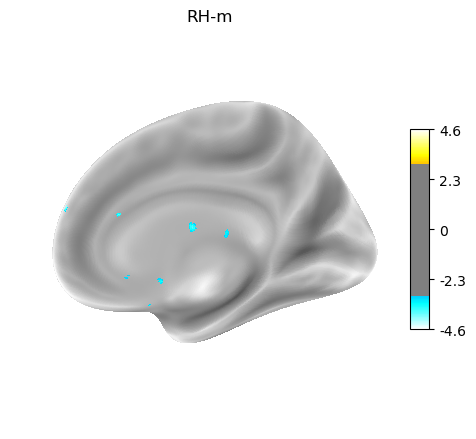

In [97]:
# Controls POST-PRE (PLOTTING)
contrast_matrix = np.eye(controls_prevpost_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(controls_prevpost_sldm.columns)
    }

contrasts = {
    "post-pre": (basic_contrasts["post"]-basic_contrasts["pre"]),
    }      
contrasts

#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Controls Post-Pre p<0.001 uncorrected')

contrast_val = contrasts['post-pre'] 
contrast_id = 'Post-Pre'    

# LEFT HEMISPHERE: 
contrast = compute_contrast(controls_labels_lh, controls_estimates_lh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(fsaverage.infl_left, z_score, hemi='left', view='lateral',
    title="LH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score, hemi='left', view='medial',
    title="LH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

# RIGHT HEMISPHERE: 
contrast = compute_contrast(controls_labels_rh, controls_estimates_rh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='lateral',
    title="RH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='medial',
    title="RH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

In [ ]:
#### POST-HOC WITHIN-SESSION PATIENTS-CONTROLS ####

In [98]:
# separating input matrix for post-hoc tests 

#lh 
second_level_input_lh = []
for i in file_lists_lh['self-other']:
    second_level_input_lh.append(i.effect_size())

second_level_input_lh = np.concatenate(second_level_input_lh,axis=0)  

#rh 
second_level_input_rh = []
for i in file_lists_rh['self-other']:
    second_level_input_rh.append(i.effect_size())

second_level_input_rh = np.concatenate(second_level_input_rh,axis=0) 

# Separate sessions and create sets for quick lookup
ses01_patients = {entry for entry in sub_order_rh['self-other'] if entry.startswith('sub1') and entry.endswith('ses01')}
ses01_patient_indices = [i for i, entry in enumerate(sub_order_rh['self-other']) if entry.startswith('sub1') and entry.endswith('ses01')]
ses01_patient_data_rh = np.array([second_level_input_rh[i] for i in ses01_patient_indices])
ses01_patient_data_lh = np.array([second_level_input_lh[i] for i in ses01_patient_indices])

ses02_patients = {entry for entry in sub_order_rh['self-other'] if entry.startswith('sub1') and entry.endswith('ses02')}
ses02_patient_indices = [i for i, entry in enumerate(sub_order_rh['self-other']) if entry.startswith('sub1') and entry.endswith('ses02')]
ses02_patient_data_rh = np.array([second_level_input_rh[i] for i in ses02_patient_indices])
ses02_patient_data_lh = np.array([second_level_input_lh[i] for i in ses02_patient_indices])

ses01_controls = {entry for entry in sub_order_rh['self-other'] if entry.startswith('sub2') and entry.endswith('ses01')}
ses01_controls_indices = [i for i, entry in enumerate(sub_order_rh['self-other']) if entry.startswith('sub2') and entry.endswith('ses01')]
ses01_controls_data_rh = np.array([second_level_input_rh[i] for i in ses01_controls_indices])
ses01_controls_data_lh = np.array([second_level_input_lh[i] for i in ses01_controls_indices])

ses02_controls = {entry for entry in sub_order_rh['self-other'] if entry.startswith('sub2') and entry.endswith('ses02')}
ses02_controls_indices = [i for i, entry in enumerate(sub_order_rh['self-other']) if entry.startswith('sub2') and entry.endswith('ses02')]
ses02_controls_data_rh = np.array([second_level_input_rh[i] for i in ses02_controls_indices])
ses02_controls_data_lh = np.array([second_level_input_lh[i] for i in ses02_controls_indices])


In [99]:
#within session input matrices  
#making second level input matrix -- 
pre_patientsvcontrols_lh = np.concatenate((ses01_patient_data_lh,ses01_controls_data_lh))
pre_patientsvcontrols_rh = np.concatenate((ses01_patient_data_rh,ses01_controls_data_rh))
post_patientsvcontrols_lh = np.concatenate((ses02_patient_data_lh,ses02_controls_data_lh))
post_patientsvcontrols_rh = np.concatenate((ses02_patient_data_rh,ses02_controls_data_rh))

In [100]:
#pre/post second level design matrices (patients / controls sep) 

#pre  
# session variable
patients = []
session1 = np.ones(len(ses01_patients))
session2 = np.zeros(len(ses01_controls))
patients = np.concatenate((session1,session2))
patients = np.expand_dims(patients, axis = -1)

controls = []
session1 = np.zeros(len(ses01_patients))
session2 = np.ones(len(ses01_controls))
controls = np.concatenate((session1,session2))
controls = np.expand_dims(controls, axis = -1)

# put all together 
pre_sldm = np.hstack((patients,controls))

#pre  
# session variable
patients = []
session1 = np.ones(len(ses02_patients))
session2 = np.zeros(len(ses02_controls))
patients = np.concatenate((session1,session2))
patients = np.expand_dims(patients, axis = -1)

controls = []
session1 = np.zeros(len(ses02_patients))
session2 = np.ones(len(ses02_controls))
controls = np.concatenate((session1,session2))
controls = np.expand_dims(controls, axis = -1)

# put all together 
post_sldm = np.hstack((patients,controls))

In [101]:
# fitting second level glm! 
pre_labels_lh, pre_estimates_lh = run_glm(pre_patientsvcontrols_lh, pre_sldm)
pre_labels_rh, pre_estimates_rh = run_glm(pre_patientsvcontrols_rh, pre_sldm)

post_labels_lh, post_estimates_lh = run_glm(post_patientsvcontrols_lh, post_sldm)
post_labels_rh, post_estimates_rh = run_glm(post_patientsvcontrols_rh, post_sldm)

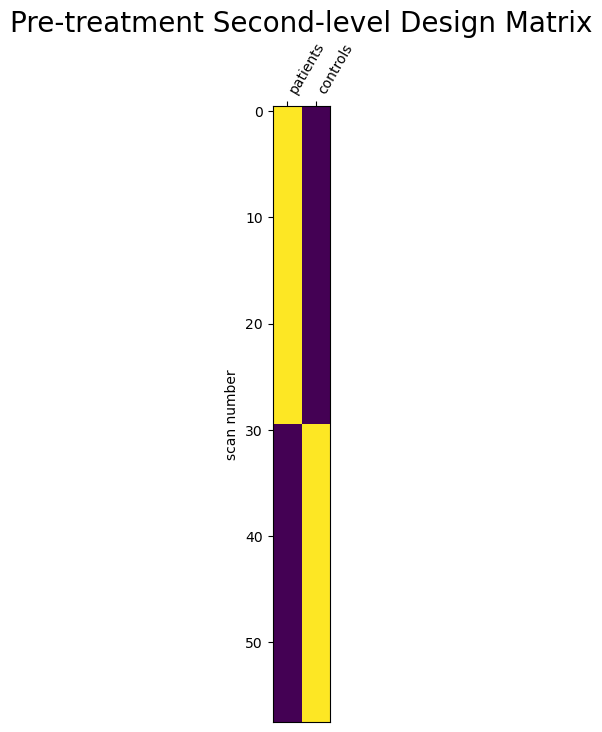

In [102]:
# plotting second level design matrix + adding column names for contrasts 
pre_sldm = pd.DataFrame(pre_sldm, columns=['patients'] +['controls'])
pre_sldm.to_excel("/Users/angelafang/Desktop/pre_sldm.xlsx")

from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(pre_sldm, rescale=False)
plt.title("Pre-treatment Second-level Design Matrix", fontsize=20)
plotting.show()

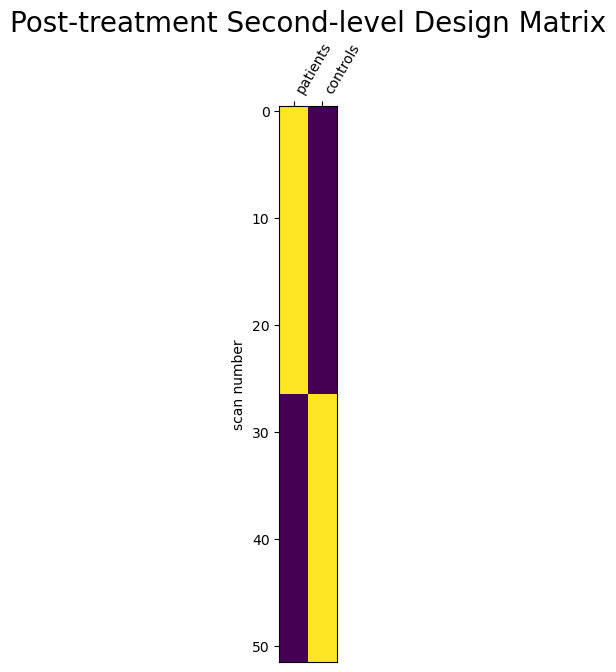

In [103]:
# plotting second level design matrix + adding column names for contrasts 
post_sldm = pd.DataFrame(post_sldm, columns=['patients'] +['controls'])
post_sldm.to_excel("/Users/angelafang/Desktop/post_sldm.xlsx")

from nilearn.glm.second_level import SecondLevelModel 
plotting.plot_design_matrix(post_sldm, rescale=False)
plt.title("Post-treatment Second-level Design Matrix", fontsize=20)
plotting.show()

Pre Patients-Controls p<0.001 uncorrected


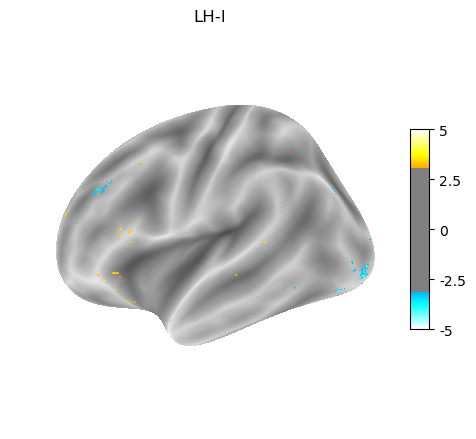

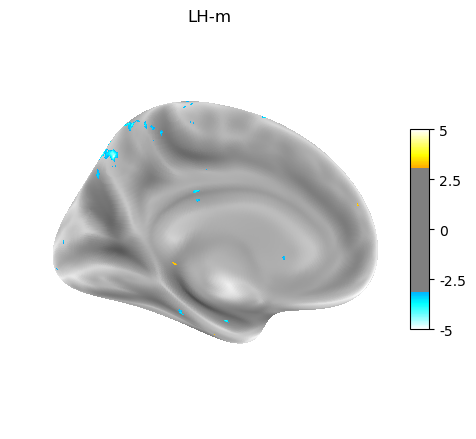

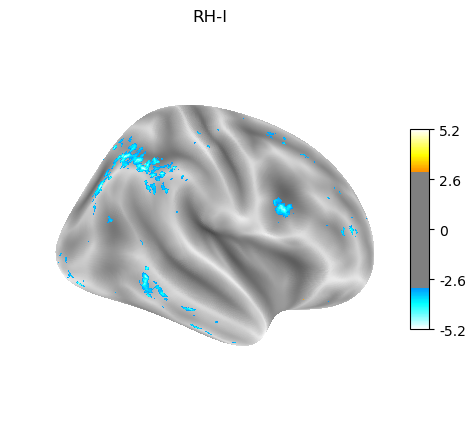

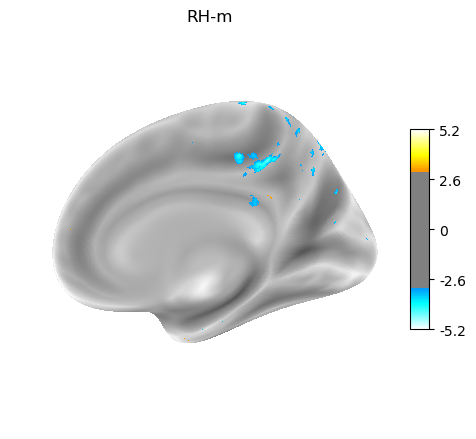

In [104]:
# PRE TREATMENT PATIENTS-CONTROLS (PLOTTING)
contrast_matrix = np.eye(pre_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(pre_sldm.columns)
    }

contrasts = {
    "patients-controls": (basic_contrasts["patients"]-basic_contrasts["controls"]),
    }      
contrasts

#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Pre Patients-Controls p<0.001 uncorrected')

contrast_val = contrasts['patients-controls'] 
contrast_id = 'patients-controls'    

# LEFT HEMISPHERE: 
contrast = compute_contrast(pre_labels_lh, pre_estimates_lh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(fsaverage.infl_left, z_score, hemi='left', view='lateral',
    title="LH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score, hemi='left', view='medial',
    title="LH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

# RIGHT HEMISPHERE: 
contrast = compute_contrast(pre_labels_rh, pre_estimates_rh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='lateral',
    title="RH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='medial',
    title="RH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

In [125]:
contrast_val = np.array([1])
type(contrast_val)

numpy.ndarray

Post Patients-Controls p<0.001 uncorrected


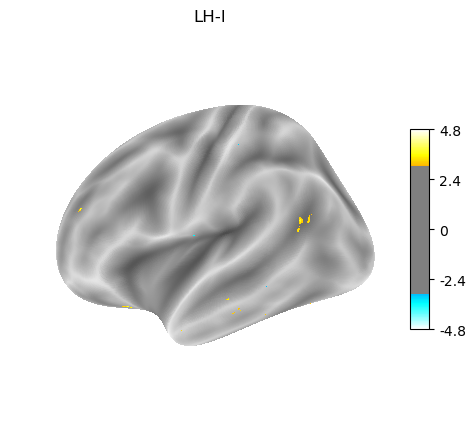

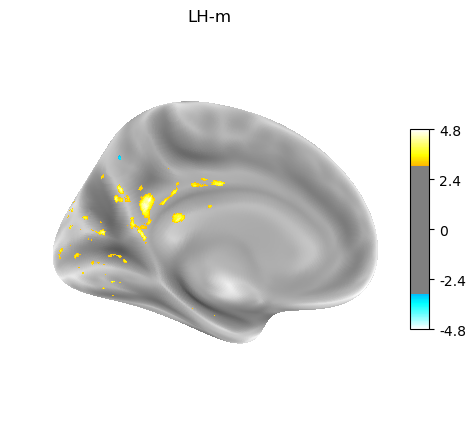

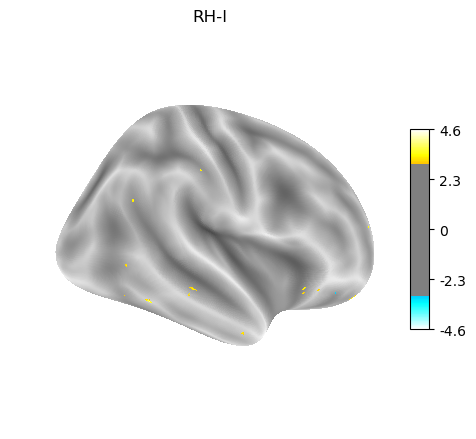

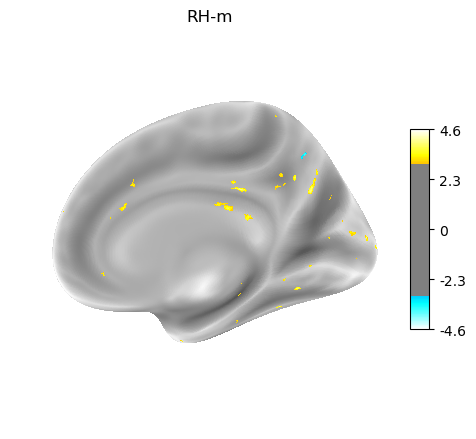

In [105]:
# POST TREATMENT PATIENTS-CONTROLS (PLOTTING)
contrast_matrix = np.eye(post_sldm.shape[1])
basic_contrasts = {
    column: contrast_matrix[i]
    for i, column in enumerate(post_sldm.columns)
    }

contrasts = {
    "patients-controls": (basic_contrasts["patients"]-basic_contrasts["controls"]),
    }      
contrasts

#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Post Patients-Controls p<0.001 uncorrected')

contrast_val = contrasts['patients-controls'] 
contrast_id = 'patients-controls'    

# LEFT HEMISPHERE: 
contrast = compute_contrast(post_labels_lh, post_estimates_lh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(fsaverage.infl_left, z_score, hemi='left', view='lateral',
    title="LH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score, hemi='left', view='medial',
    title="LH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

# RIGHT HEMISPHERE: 
contrast = compute_contrast(post_labels_rh, post_estimates_rh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='lateral',
    title="RH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='medial',
    title="RH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

In [ ]:
#### WITHIN SUBJECTS, WITHIN SESSION SELF VS OTHER ###

In [107]:
# separating input matrix for post-hoc tests 

#lh 
second_level_input_lh = []
for i in file_lists_lh['self-other']:
    second_level_input_lh.append(i.effect_size())

second_level_input_lh = np.concatenate(second_level_input_lh,axis=0)  

#rh 
second_level_input_rh = []
for i in file_lists_rh['self-other']:
    second_level_input_rh.append(i.effect_size())

second_level_input_rh = np.concatenate(second_level_input_rh,axis=0) 

# Separate sessions and create sets for quick lookup
ses01_patients = {entry for entry in sub_order_rh['self-other'] if entry.startswith('sub1') and entry.endswith('ses01')}
ses01_patient_indices = [i for i, entry in enumerate(sub_order_rh['self-other']) if entry.startswith('sub1') and entry.endswith('ses01')]
ses01_patient_data_rh = np.array([second_level_input_rh[i] for i in ses01_patient_indices])
ses01_patient_data_lh = np.array([second_level_input_lh[i] for i in ses01_patient_indices])

ses02_patients = {entry for entry in sub_order_rh['self-other'] if entry.startswith('sub1') and entry.endswith('ses02')}
ses02_patient_indices = [i for i, entry in enumerate(sub_order_rh['self-other']) if entry.startswith('sub1') and entry.endswith('ses02')]
ses02_patient_data_rh = np.array([second_level_input_rh[i] for i in ses02_patient_indices])
ses02_patient_data_lh = np.array([second_level_input_lh[i] for i in ses02_patient_indices])

ses01_controls = {entry for entry in sub_order_rh['self-other'] if entry.startswith('sub2') and entry.endswith('ses01')}
ses01_controls_indices = [i for i, entry in enumerate(sub_order_rh['self-other']) if entry.startswith('sub2') and entry.endswith('ses01')]
ses01_controls_data_rh = np.array([second_level_input_rh[i] for i in ses01_controls_indices])
ses01_controls_data_lh = np.array([second_level_input_lh[i] for i in ses01_controls_indices])

ses02_controls = {entry for entry in sub_order_rh['self-other'] if entry.startswith('sub2') and entry.endswith('ses02')}
ses02_controls_indices = [i for i, entry in enumerate(sub_order_rh['self-other']) if entry.startswith('sub2') and entry.endswith('ses02')]
ses02_controls_data_rh = np.array([second_level_input_rh[i] for i in ses02_controls_indices])
ses02_controls_data_lh = np.array([second_level_input_lh[i] for i in ses02_controls_indices])

In [119]:
#second level design matrix (just column of 1's) 

patients_ses01_sldm = np.ones(len(ses01_patients))
patients_ses02_sldm = np.ones(len(ses02_patients))
controls_ses01_sldm = np.ones(len(ses01_controls))
controls_ses02_sldm = np.ones(len(ses02_controls))
patients_ses01_sldm = np.expand_dims(patients_ses01_sldm, axis = -1)
patients_ses02_sldm = np.expand_dims(patients_ses02_sldm, axis = -1)
controls_ses01_sldm = np.expand_dims(controls_ses01_sldm, axis = -1)
controls_ses02_sldm = np.expand_dims(controls_ses02_sldm, axis = -1)
patients_ses01_sldm.shape


(30, 1)

In [120]:
# fitting second level glm! 
patients_ses01_labels_lh, patients_ses01_estimates_lh = run_glm(ses01_patient_data_lh, patients_ses01_sldm)
patients_ses02_labels_lh, patients_ses02_estimates_lh = run_glm(ses02_patient_data_lh, patients_ses02_sldm)
patients_ses01_labels_rh, patients_ses01_estimates_rh = run_glm(ses01_patient_data_rh, patients_ses01_sldm)
patients_ses02_labels_rh, patients_ses02_estimates_rh = run_glm(ses02_patient_data_rh, patients_ses02_sldm)

controls_ses01_labels_lh, controls_ses01_estimates_lh = run_glm(ses01_controls_data_lh, controls_ses01_sldm)
controls_ses02_labels_lh, controls_ses02_estimates_lh = run_glm(ses02_controls_data_lh, controls_ses02_sldm)
controls_ses01_labels_rh, controls_ses01_estimates_rh = run_glm(ses01_controls_data_rh, controls_ses01_sldm)
controls_ses02_labels_rh, controls_ses02_estimates_rh = run_glm(ses02_controls_data_rh, controls_ses02_sldm)

Pre-treatment, Patients, Self-Other p<0.001 uncorrected


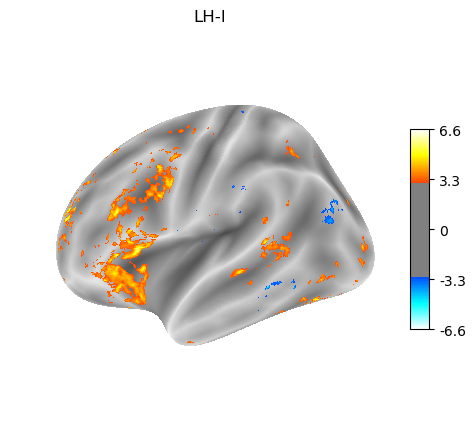

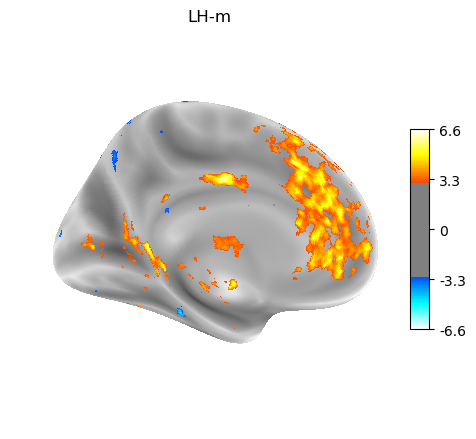

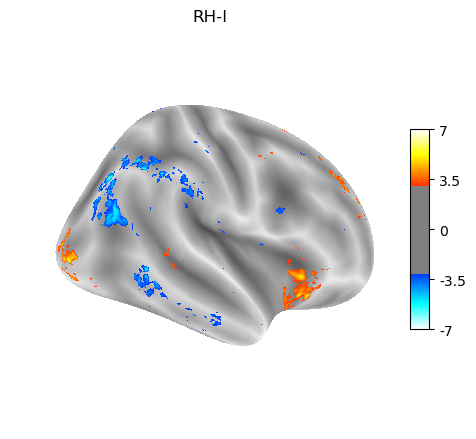

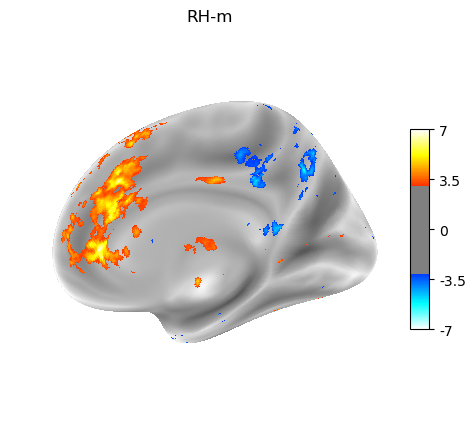

In [126]:
# PRE TREATMENT PATIENTS

#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Pre-treatment, Patients, Self-Other p<0.001 uncorrected')

contrast_val = np.array([1])   

# LEFT HEMISPHERE: 
contrast = compute_contrast(patients_ses01_labels_lh, patients_ses01_estimates_lh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(fsaverage.infl_left, z_score, hemi='left', view='lateral',
    title="LH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score, hemi='left', view='medial',
    title="LH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

# RIGHT HEMISPHERE: 
contrast = compute_contrast(patients_ses01_labels_rh, patients_ses01_estimates_rh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='lateral',
    title="RH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='medial',
    title="RH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

Post-treatment, Patients, Self-Other p<0.001 uncorrected


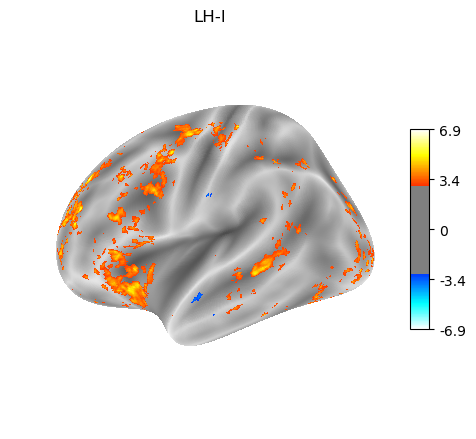

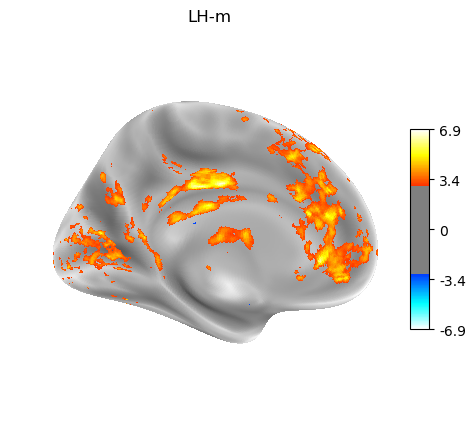

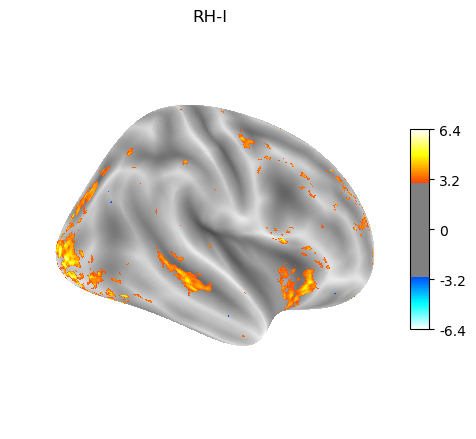

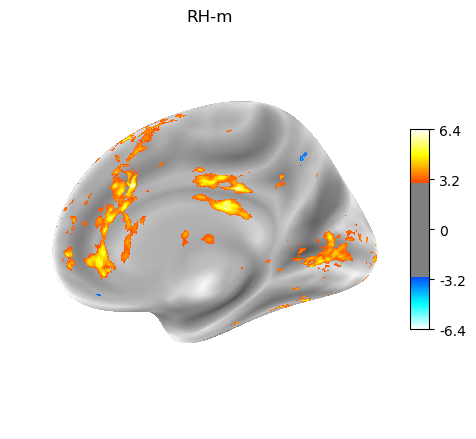

In [127]:
# POST TREATMENT PATIENTS

#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Post-treatment, Patients, Self-Other p<0.001 uncorrected')

contrast_val = np.array([1])   

# LEFT HEMISPHERE: 
contrast = compute_contrast(patients_ses02_labels_lh, patients_ses02_estimates_lh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(fsaverage.infl_left, z_score, hemi='left', view='lateral',
    title="LH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score, hemi='left', view='medial',
    title="LH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

# RIGHT HEMISPHERE: 
contrast = compute_contrast(patients_ses02_labels_rh, patients_ses02_estimates_rh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='lateral',
    title="RH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='medial',
    title="RH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

Pre-treatment, Controls, Self-Other p<0.001 uncorrected


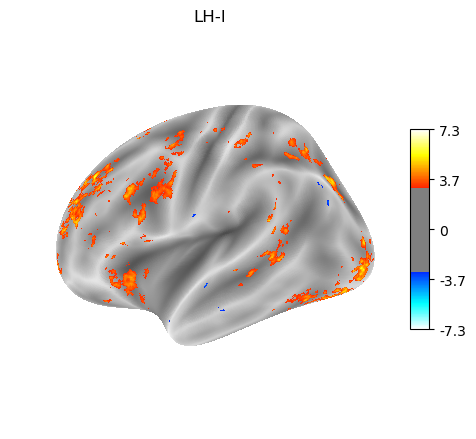

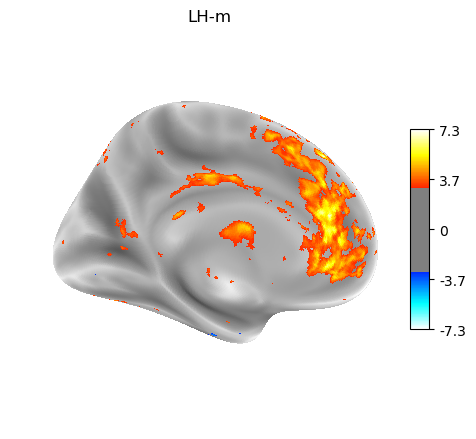

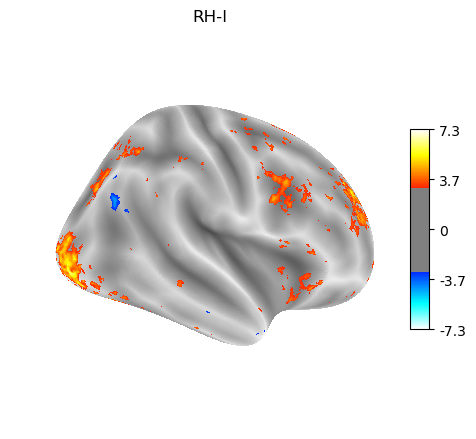

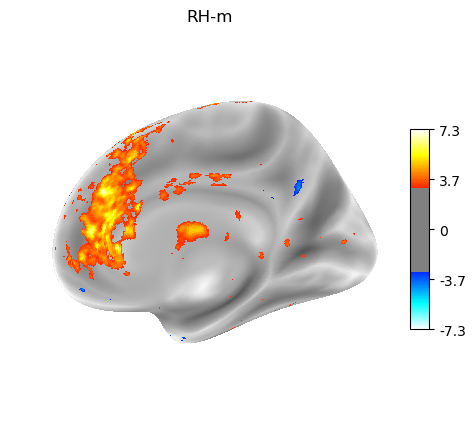

In [128]:
# PRE TREATMENT Controls

#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Pre-treatment, Controls, Self-Other p<0.001 uncorrected')

contrast_val = np.array([1])   

# LEFT HEMISPHERE: 
contrast = compute_contrast(controls_ses01_labels_lh, controls_ses01_estimates_lh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(fsaverage.infl_left, z_score, hemi='left', view='lateral',
    title="LH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score, hemi='left', view='medial',
    title="LH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

# RIGHT HEMISPHERE: 
contrast = compute_contrast(controls_ses01_labels_rh, controls_ses01_estimates_rh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='lateral',
    title="RH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='medial',
    title="RH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

Post-treatment, Controls, Self-Other p<0.001 uncorrected


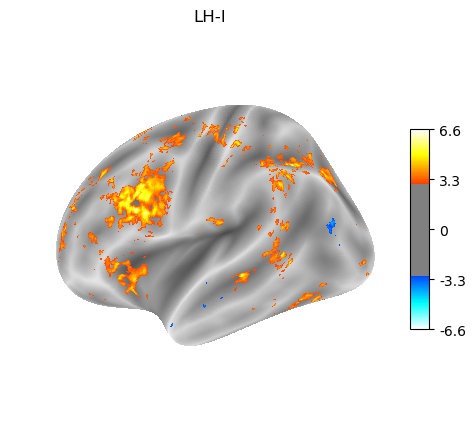

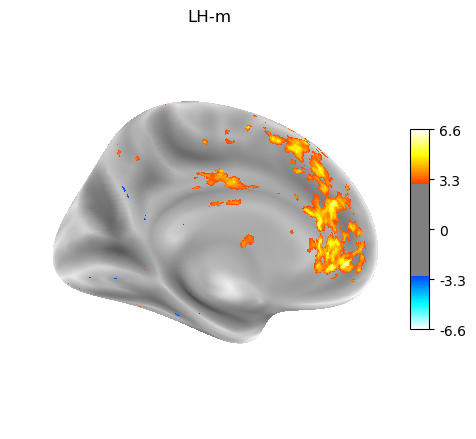

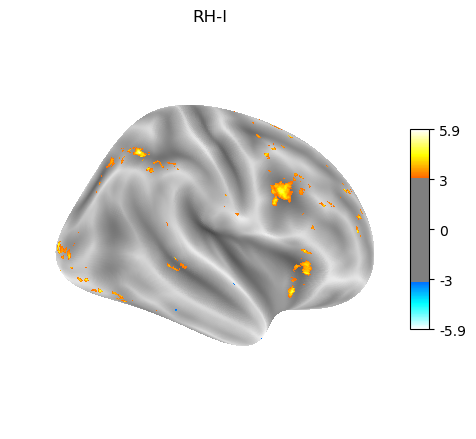

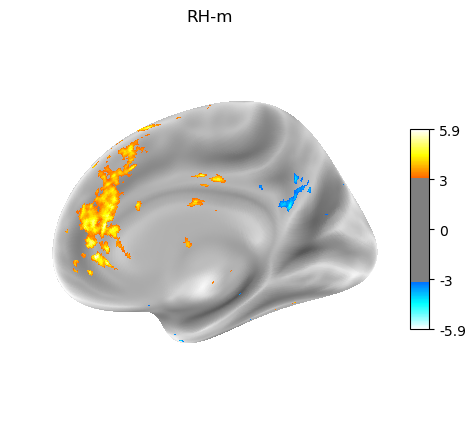

In [129]:
# POST TREATMENT Controls

#Plotting! <0.001 uncorrected 
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting

p001_unc = norm.isf(0.001)

# Add a bolded super title
print('Post-treatment, Controls, Self-Other p<0.001 uncorrected')

contrast_val = np.array([1])   

# LEFT HEMISPHERE: 
contrast = compute_contrast(controls_ses02_labels_lh, controls_ses02_estimates_lh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(fsaverage.infl_left, z_score, hemi='left', view='lateral',
    title="LH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_left, z_score, hemi='left', view='medial',
    title="LH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_left)
plotting.show()

# RIGHT HEMISPHERE: 
contrast = compute_contrast(controls_ses02_labels_rh, controls_ses02_estimates_rh, contrast_val)
z_score = contrast.z_score()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='lateral',
    title="RH-l", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

plotting.plot_surf_stat_map(
    fsaverage.infl_right, z_score, hemi='right', view='medial',
    title="RH-m", colorbar=True,
    threshold=p001_unc, bg_map=fsaverage.sulc_right)
plotting.show()

In [ ]:
#saving outputs: 
from nipype.interfaces import freesurfer

ERROR: Could not find a version that satisfies the requirement freesurfer (from versions: none)
ERROR: No matching distribution found for freesurfer
Note: you may need to restart the kernel to use updated packages.
